In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="7"
from cuml.ensemble import RandomForestClassifier
from cuml import LogisticRegression
from sklearn.ensemble import VotingClassifier
from cuml.common.device_selection import set_global_device_type, get_global_device_type
from model.tuning import *
from dataclasses import dataclass, asdict

set_global_device_type('gpu')
print('new device type:', get_global_device_type())

new device type: DeviceType.device


In [2]:
def ensemble_classifier(max_depth, n_estimators, C, l1_ratio, penalty, rfc_weight, n_bins):
    # define classifiers
    rfc = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, n_bins=n_bins)
    lr = LogisticRegression(C=C, l1_ratio=l1_ratio, penalty=penalty)
    
    # define voting ensemble
    voting_model = VotingClassifier(
        estimators=[
            ('rfc', rfc), 
            ('lr', lr),
        ],
        voting='soft',
        weights=[rfc_weight, 1.0-rfc_weight],
    )
    return voting_model

@dataclass
class SampleEvalObj:
    sample_size: int
    acc: float
    micro_f1: float
    macro_f1: float
    dict = asdict

In [3]:
# define model to optimize
model_function = ensemble_classifier
model_name = "voting_ensemble"

# define hyperparameter ranges to search
# we aren't optimizing hyperparams so we'll leave this blank
hparam_range_dict = {}

# define optimizer
hparam_optimizer = HyperParamOptimizer(
    model_function=model_function, 
    model_name=model_name, 
    hparam_range_dict=hparam_range_dict
)

In [4]:
# load data into optimizer
train_val_path = "./data/fallreports_2023-9-21_train.csv"
test_path = "./data/fallreports_2023-9-21_test.csv"
hparam_optimizer.load_data(
    train_val_path=train_val_path, 
    test_path=test_path
)

Data loaded...


In [5]:
hparam_optimizer.train_val_df

,record_id,redcap_repeat_instrument,gender,race,ethnicity,education,age_at_enrollment,pd_duration,num_falls_6_mo,previous_falls,...,location_binary,fall_description,fall_class,fog_yn,fall_desc_repeat,aime2023_dataset,last_followup,fall_total,fall_rate,category
0,66,Fall Report,Male,White,Not Hispanic or Latino,Completed college,60,2.4,None,non-faller,...,No,The patient was hiking. He tripped on an expos...,BoS (slips / trips),No,No,Yes,378,1,0.002646,train
1,28,Fall Report,Male,White,Not Hispanic or Latino,Completed college,56,8.0,3 or more,faller,...,Yes,The patient was reaching forward for his phone...,CoM (self-induced or externally-applied),No,No,No,402,231,0.574627,train
2,57,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,69,2.7,None,non-faller,...,No,The patient was digging a hole to plant an aza...,BoS (slips / trips),No,No,Yes,394,8,0.020305,train
3,39,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,76,9.7,3 or more,faller,...,Yes,The patient was walking towards the kitchen ta...,CoM (self-induced or externally-applied),No,No,Yes,96,480,5.000000,train
4,55,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,56,9.8,1,faller,...,No,The patient was home playing catch in backyard...,"Unclassifiable (falls from bed, sports-related...",No,No,Yes,391,2,0.005115,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,16,Fall Report,Female,White,Not Hispanic or Latino,Completed high school,64,7.9,3 or more,faller,...,Yes,The patient was in the living room trying to s...,CoM (self-induced or externally-applied),No,No,Yes,371,12,0.032345,train
295,122,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,65,7.1,1,faller,...,No,The patient was at the supermarket. He took on...,CoM (self-induced or externally-applied),No,No,Yes,383,8,0.020888,train
296,39,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,76,9.7,3 or more,faller,...,Yes,The patient was walking to the kitchen counter...,CoM (self-induced or externally-applied),No,No,Yes,96,480,5.000000,train
297,56,Fall Report,Female,White,Not Hispanic or Latino,"Completed junior college (associate's degree, ...",65,15.7,3 or more,faller,...,Yes,The patient was in their bathroom and there wa...,BoS (slips / trips),No,No,No,380,37,0.097368,train


In [6]:
# set model parameters
ngram_list = [1, 2]
target_feature = 'fog_q_class'
vector_type = 'tf-idf'
n_features = 250
augment_dict = {
    'token_length': True, 
    'patient_demographics': True, 
    'mds_updrs': True,
    'moca': True
}
seed = 13
k = 30
constant_dict = {} # {'cache_size': 6_000}
hparam_optimizer.set_params(
    ngram_list=ngram_list, 
    target_feature=target_feature, 
    vector_type=vector_type, 
    n_features=n_features, 
    augment_dict=augment_dict, 
    seed=seed,
    k=k,
    constant_dict=constant_dict
)

Parameters updated...


In [7]:
ensemble_best_param_dict = {
    'C': 2045.7891312130546,
    'l1_ratio': 0.049833394439413,
    'max_depth': 48.12718850106587,
    'n_estimators': 97.06033604146855,
    'penalty': 'elasticnet',
    'rfc_weight': 0.855137554079295
}

sample_size_list = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 299]

eval_list = []
for sample_size in sample_size_list:
    print(f"\nSample Size: {sample_size}")
    acc, micro_f1, macro_f1 = hparam_optimizer.objective_function(
        ensemble_best_param_dict, 
        sample_size=sample_size, 
        log=False, 
        return_all=True,
        rfc=True
    )
    eval_list.append(SampleEvalObj(sample_size, acc, micro_f1, macro_f1))


Sample Size: 25
Randomly sampling 30 sets with size 25 from train set...

Accuracy: 0.6944
Micro-Averaged F1: 0.6650
Macro-Averaged F1: 0.6360

Sample Size: 50
Randomly sampling 30 sets with size 50 from train set...

Accuracy: 0.7920
Micro-Averaged F1: 0.7750
Macro-Averaged F1: 0.7662

Sample Size: 75
Randomly sampling 30 sets with size 75 from train set...
[W] [12:58:25.442964] QWL-QN: max iterations reached
[W] [12:58:25.443152] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:58:41.703219] QWL-QN: max iterations reached
[W] [12:58:41.703413] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.

Accuracy: 0.8033
Micro-Averaged F1: 0.7861
Macro-Averaged F1: 0.7826

Sample Size: 100
Randomly sampling 30 sets with size 100 from t

[W] [12:59:52.918934] QWL-QN: max iterations reached
[W] [12:59:52.919043] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:59:56.009186] QWL-QN: max iterations reached
[W] [12:59:56.009355] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [12:59:59.288253] QWL-QN: max iterations reached
[W] [12:59:59.288361] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:00:00.883818] QWL-QN: max iterations reached
[W] [13:00:00.883901] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:01:12.400524] QWL-QN: max iterations reached
[W] [13:01:12.400717] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:01:15.408213] QWL-QN: max iterations reached
[W] [13:01:15.408364] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:01:18.778776] QWL-QN: max iterations reached
[W] [13:01:18.778887] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:01:21.944077] QWL-QN: max iterations reached
[W] [13:01:21.944246] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:02:52.571490] QWL-QN: max iterations reached
[W] [13:02:52.571668] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:02:55.777021] QWL-QN: max iterations reached
[W] [13:02:55.777192] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:02:58.954497] QWL-QN: max iterations reached
[W] [13:02:58.954714] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:03:02.129135] QWL-QN: max iterations reached
[W] [13:03:02.129302] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:04:29.698580] QWL-QN: max iterations reached
[W] [13:04:29.698713] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:04:32.859653] QWL-QN: max iterations reached
[W] [13:04:32.859791] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:04:36.042775] QWL-QN: max iterations reached
[W] [13:04:36.042878] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:04:42.440995] QWL-QN: max iterations reached
[W] [13:04:42.441103] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:06:14.559649] QWL-QN: max iterations reached
[W] [13:06:14.559833] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:06:17.669388] QWL-QN: max iterations reached
[W] [13:06:17.669553] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:06:20.951491] QWL-QN: max iterations reached
[W] [13:06:20.951791] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:06:23.985590] QWL-QN: max iterations reached
[W] [13:06:23.985757] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:07:55.991670] QWL-QN: max iterations reached
[W] [13:07:55.991852] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:07:59.161865] QWL-QN: max iterations reached
[W] [13:07:59.162039] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:08:02.286717] QWL-QN: max iterations reached
[W] [13:08:02.286903] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:08:05.466853] QWL-QN: max iterations reached
[W] [13:08:05.467140] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:09:42.102173] QWL-QN: max iterations reached
[W] [13:09:42.102306] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:09:45.282415] QWL-QN: max iterations reached
[W] [13:09:45.282617] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:09:48.448083] QWL-QN: max iterations reached
[W] [13:09:48.448335] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:09:51.597788] QWL-QN: max iterations reached
[W] [13:09:51.597986] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

[W] [13:11:32.949934] QWL-QN: max iterations reached
[W] [13:11:32.950038] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:11:37.557126] QWL-QN: max iterations reached
[W] [13:11:37.557234] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:11:40.860943] QWL-QN: max iterations reached
[W] [13:11:40.861055] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
[W] [13:11:45.348633] QWL-QN: max iterations reached
[W] [13:11:45.348738] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the inpu

In [8]:
eval_df = pd.DataFrame([eval_obj.dict() for eval_obj in eval_list])

In [9]:
eval_df

,sample_size,acc,micro_f1,macro_f1
0,25,0.694366,0.664951,0.635963
1,50,0.792019,0.775012,0.766210
2,75,0.803286,0.786115,0.782623
3,100,0.838498,0.830374,0.828992
4,125,0.846948,0.841285,0.840057
5,150,0.851174,0.843611,0.842698
6,175,0.857277,0.852140,0.850938
7,200,0.856338,0.850585,0.849894
8,225,0.860094,0.855058,0.854666
9,250,0.872300,0.869230,0.868771


In [20]:
eval_df.to_csv('./sample_size_analysis.csv')

In [1]:
import pandas as pd
eval_df = pd.read_csv('./sample_size_analysis.csv')

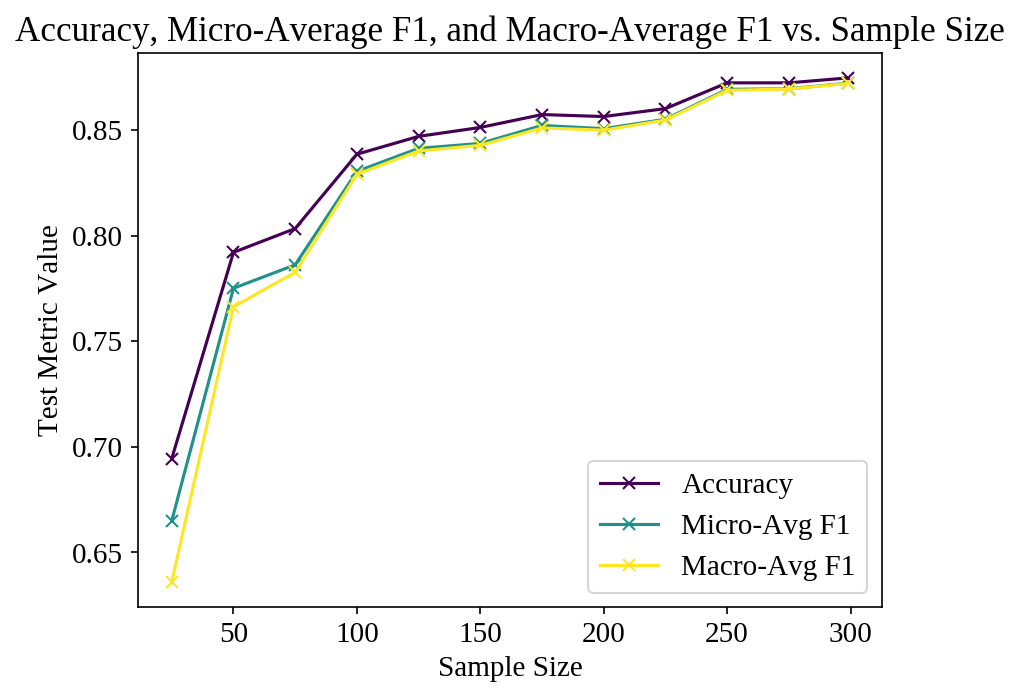

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# set font params
mpl.font_manager.fontManager.addfont('Tinos-Regular.ttf')
mpl.rc('font', family='Tinos')
plt.rcParams.update({'font.size': 14})

# set figure dpi
fig = plt.figure(dpi=150)
ax = plt.gca()

# Plotting the columns against 'sample_size'
eval_df.plot(x='sample_size', y=['acc', 'micro_f1', 'macro_f1'], marker='x', cmap='viridis', ax=ax)

# Adding labels and title
plt.xlabel('Sample Size')
plt.ylabel('Test Metric Value')
plt.title('Accuracy, Micro-Average F1, and Macro-Average F1 vs. Sample Size')
plt.legend(loc='lower right', labels=['Accuracy', 'Micro-Avg F1', 'Macro-Avg F1'])  # This ensures the best position for the legend

# Show the plot
plt.show()